# LED test: TimePix vs CMOS (FLASH DAQ)

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Imports

In [5]:
import h5py
import os.path
from datetime import datetime
import matplotlib.pyplot as plt

### Define files

In [7]:
file_path = 'data/'

hdf_file_name = 'run_0000_20191207-1419.hdf5'
hdf_file_complete_path = file_path + hdf_file_name
assert os.path.isfile(hdf_file_complete_path), 'File does not exist!'

live_file_name = 'run_0000_20191207-1419.trainID'
live_file_complete_path = file_path + live_file_name
assert os.path.isfile(live_file_complete_path), 'File does not exist!'

### Time stamps from HDF5 file

In [135]:
def data_from_hdf(hdf_file_complete_path):
    with h5py.File(hdf_file_complete_path, 'r') as h_file:
        timestamps_data = h_file['timeStamps/ns'][:]
        triggerIDs_data = h_file['timeStamps/nr'][:]
    print('Reading from HDF5 - number of events: {}'.format(len(triggerIDs_data)))
    return timestamps_data, triggerIDs_data

In [136]:
timestamps_data, triggerIDs_data = data_from_hdf(hdf_file_complete_path)

print('First train:',datetime.utcfromtimestamp(int(timestamps_data[0]*1E-9)).strftime('%Y-%m-%d %H:%M:%S'))
print('Last train: ',datetime.utcfromtimestamp(int(timestamps_data[-1]*1E-9)).strftime('%Y-%m-%d %H:%M:%S'))

Reading from HDF5 - number of events: 5878
First train: 2019-12-07 13:19:02
Last train:  2019-12-07 13:29:01


### Timestamps and trainIDs from .trainID file

In [137]:
def read_trainID_usb_file(live_file_complete_path):
    trainIDs_usb = []
    timestamp_usb = []
    with open(live_file_complete_path, 'rb') as f:
        while True:
            try:
                timestamp_usb.append(np.load(f))
                trainIDs_usb.append((np.load(f)))
            except:
                break
    trainIDs_usb = np.row_stack(trainIDs_usb).ravel()
    timestamp_usb = np.row_stack(timestamp_usb).ravel()
    print('Reading from trainID file - number of events: {}'.format(len(timestamp_usb)))
    return trainIDs_usb, timestamp_usb


In [138]:
trainIDs_usb, timestamp_usb = read_trainID_usb_file(live_file_complete_path)

print('First train:',datetime.utcfromtimestamp(int(timestamp_usb[0]*1E-9)).strftime('%Y-%m-%d %H:%M:%S'))
print('Last train: ',datetime.utcfromtimestamp(int(timestamp_usb[-1]*1E-9)).strftime('%Y-%m-%d %H:%M:%S'))

Reading from trainID file - number of events: 6023
First train: 2019-12-07 13:19:02
Last train:  2019-12-07 13:29:03


In [139]:
print('trainID | timeStamp in ns * 1E-8 ')
for i in range(15):
    print(trainIDs_usb[i], timestamp_usb[i] * 1.E-8)

trainID | timeStamp in ns * 1E-8 
609622077 15757247421.342201
609622078 15757247421.458017
609622079 15757247421.500301
609622080 15757247421.545822
609622081 15757247421.58828
609622082 15757247421.635218
609622083 15757247421.683651
609622084 15757247421.733313
609622085 15757247421.785797
609635368 15757247422.533998
609635369 15757247423.493792
609635370 15757247424.610813
609635371 15757247425.570852
609635372 15757247426.53224
609635373 15757247427.491352


#### Cut events for .trainID file
first 10 and very last trainID - empirically found for this run

In [140]:
trainIDs_usb = trainIDs_usb[10:-16]
timestamp_usb = timestamp_usb[10:-16]

In [141]:
def cut_ts(single_ts):          
    #return int(single_ts/1.E7+0.5)
    return single_ts/1.E8

def cut_ts_array(array_ts):
    ts_cutted = []
    for i in range(len(array_ts)):
        ts_cutted.append(cut_ts(array_ts[i]))
    return ts_cutted

def print_unique_after_cut(array,name):
    ts_cutted = cut_ts_array(array)
    u, indices = np.unique(ts_cutted, return_index=True)
    print(name,'|',len(array),'|unique:', len(indices),' |', indices)
    return np.array(ts_cutted), np.array(indices)
    

In [142]:
usb_ts_cutted, ind1 = print_unique_after_cut(timestamp_usb, 'usb ')
data_ts_cutted, ind2 = print_unique_after_cut(timestamps_data, 'data')

usb  | 5997 |unique: 5997  | [   0    1    2 ... 5994 5995 5996]
data | 5878 |unique: 5878  | [   0    1    2 ... 5875 5876 5877]


In [143]:
data_ts_corrected = data_ts_cutted
trigger_corrected = triggerIDs_data

tt = []
    
for i in range(len(triggerIDs_data)-1):
    if triggerIDs_data[i+1] - triggerIDs_data[i]>1:
        tt.append(triggerIDs_data[i])

print(len(tt))

for i in range(len(tt)):
    trigger_corrected = np.insert(trigger_corrected,tt[i]+1,0)
    data_ts_corrected = np.insert(data_ts_corrected,tt[i]+1,0)
    

119


In [144]:
for i in range(45,52):
    print(trigger_corrected[i],trainIDs_usb[i],data_ts_corrected[i], usb_ts_cutted[i]) 

45 609635414 15757247468.3527 15757247468.589972
46 609635415 15757247469.352806 15757247469.551334
47 609635416 15757247470.352365 15757247470.51135
0 609635417 0.0 15757247471.470722
49 609635418 15757247472.352036 15757247472.588
50 609635419 15757247473.351595 15757247473.5488
51 609635420 15757247474.351154 15757247474.508324


In [145]:
print(len(trigger_corrected),len(trainIDs_usb),len(data_ts_corrected),len(usb_ts_cutted))

5997 5997 5997 5997


In [164]:
def raw_events_from_hdf(hdf_file_complete_path):
    with h5py.File(hdf_file_complete_path, 'r') as h_file:
        raw_events = h_file['raw/nr'][:]
    return raw_events

In [307]:
raw_events = raw_events_from_hdf(hdf_file_complete_path)

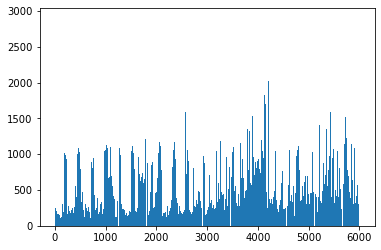

In [329]:
x = plt.hist(raw_events, len(usb_ts_cutted))

564.4783940115685


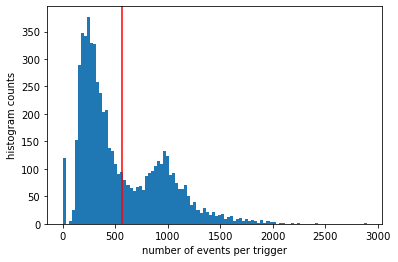

In [330]:
counts = x[0]

divider = np.average(counts[counts>0])
x = plt.hist(counts,100)
plt.axvline(divider, c='r')
plt.xlabel('number of events per trigger')
plt.ylabel('histogram counts')
print(divider)

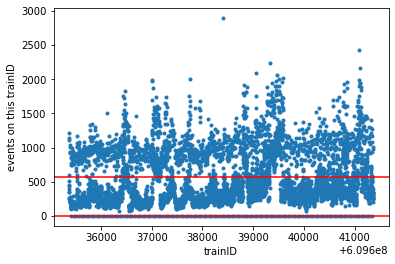

In [331]:
plt.plot(trainIDs_usb,counts,'.')
plt.axhline(divider,c='r')
plt.axhline(1,c='r')
plt.xlabel('trainID')
plt.ylabel('events on this trainID')
plt.show()

In [176]:
for i in range(45,52):
    print(trainIDs_usb[i],counts[i]) 

609635414 140.0
609635415 132.0
609635416 192.0
609635417 0.0
609635418 163.0
609635419 165.0
609635420 150.0


In [263]:
timepix_trainIDs = []
timepix_light = []

for i in range(len(counts)):
    if counts[i]>1:
        if counts[i]>divider:
            timepix_trainIDs.append(trainIDs_usb[i])
            timepix_light.append(1)
        else:
            timepix_trainIDs.append(trainIDs_usb[i])
            timepix_light.append(0)
            
print(len(timepix_trainIDs),len(timepix_light))

5878 5878


In [264]:
missing_ids = []
for i in range(len(timepix_trainIDs)-1):
    if timepix_trainIDs[i+1]-timepix_trainIDs[i] !=1:
        missing_ids.append(1)
print(len(missing_ids))


119


### CMOS camera from FLASH DAQ

In [159]:
cmos_file_name = 'cmos_light_32266.npz'
cmos_file_complete_path = file_path + cmos_file_name
assert os.path.isfile(cmos_file_complete_path), 'File does not exist!'

In [160]:
cmos_file = np.load(cmos_file_complete_path)

In [161]:
flash_trainIDs = cmos_file['trainIDs']
cmos_light = cmos_file['light']

In [207]:
flash_trainIDs = flash_trainIDs.astype(int)

### Correlation via trainID

timepix_trainIDs  - timepix_light 

flash_trainIDs - cmos_light

In [252]:
print(len(timepix_trainIDs),len(flash_trainIDs))

5878 6172


In [253]:
pos = []
for i in range(len(timepix_trainIDs)):
    for j in range(len(flash_trainIDs)):
        if timepix_trainIDs[i] == flash_trainIDs[j]:
            pos.append(j)

In [265]:
tt_flash_ids = flash_trainIDs[pos]
tt_cmos_light = cmos_light[pos]
print(len(tt_flash_ids))

5878


In [278]:
trues = []
falses = []

for i in range(len(tt_flash_ids)):
    if tt_flash_ids[i] == timepix_trainIDs[i]:
        trues.append(1)
    else:
        falses.append(1)
        
print('Trues:', len(trues), '| Falses:', len(falses))

Trues: 5878 | Falses: 0


In [316]:
tt_timepix_light = np.roll(timepix_light,0)

def test_sift(tt_timepix_light,tt_cmos_light, shift):
    tt = np.roll(tt_timepix_light,shift)
    trues = []
    falses = []
    for i in range(len(timepix_light)):
        if tt[i] == tt_cmos_light[i]:
            trues.append(1)
        else:
            falses.append(1)
    print('Trues:', len(trues), '| Falses:', len(falses),'| Ratio:',len(trues)/(len(trues)+len(falses)))
    return len(trues)/(len(trues)+len(falses))

shifts = []
corr_max = []
for i in range(-100,100):
    shifts.append(i)
    corr_max.append(test_sift(tt_timepix_light,tt_cmos_light,i))

Trues: 3442 | Falses: 2436 | Ratio: 0.5855733242599523
Trues: 3250 | Falses: 2628 | Ratio: 0.5529091527730521
Trues: 3816 | Falses: 2062 | Ratio: 0.6492004083021435
Trues: 3250 | Falses: 2628 | Ratio: 0.5529091527730521
Trues: 3198 | Falses: 2680 | Ratio: 0.5440626063286832
Trues: 3252 | Falses: 2626 | Ratio: 0.553249404559374
Trues: 3988 | Falses: 1890 | Ratio: 0.6784620619258251
Trues: 3230 | Falses: 2648 | Ratio: 0.5495066349098333
Trues: 3256 | Falses: 2622 | Ratio: 0.5539299081320177
Trues: 3308 | Falses: 2570 | Ratio: 0.5627764545763865
Trues: 3690 | Falses: 2188 | Ratio: 0.6277645457638653
Trues: 3258 | Falses: 2620 | Ratio: 0.5542701599183396
Trues: 3432 | Falses: 2446 | Ratio: 0.583872065328343
Trues: 3384 | Falses: 2494 | Ratio: 0.575706022456618
Trues: 3664 | Falses: 2214 | Ratio: 0.6233412725416808
Trues: 3204 | Falses: 2674 | Ratio: 0.5450833616876488
Trues: 3230 | Falses: 2648 | Ratio: 0.5495066349098333
Trues: 3498 | Falses: 2380 | Ratio: 0.5951003742769649
Trues: 3784 |

Text(0.5, 0, 'shift')

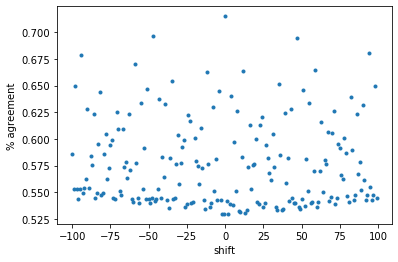

In [322]:
plt.plot(shifts, corr_max,'.')
plt.ylabel('% agreement')
plt.xlabel('shift')

In [280]:
light_diff = tt_timepix_light - tt_cmos_light

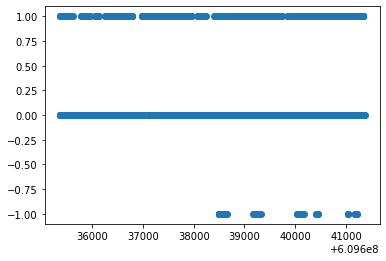

In [312]:
plt.plot(timepix_trainIDs ,light_diff,'o')
#plt.xlim(70+6.0964E8,90+6.0964E8)
#plt.xlim(1200+6.0964E8,1225+6.0964E8)

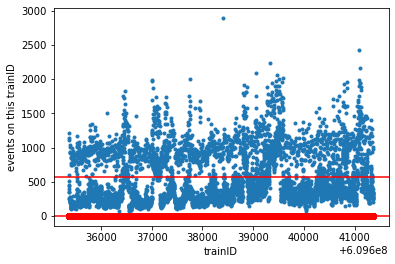

In [324]:
plt.plot(trainIDs_usb,counts,'.')
plt.plot(timepix_trainIDs ,light_diff,'ro')
plt.axhline(divider,c='r')
plt.axhline(1,c='r')
plt.xlabel('trainID')
plt.ylabel('events on this trainID')
plt.show()

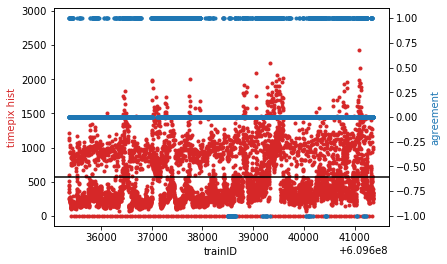

In [336]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('trainID')
ax1.set_ylabel('timepix hist', color=color)
ax1.plot(trainIDs_usb,counts, 'r.',color=color)
ax1.axhline(divider,c='k')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('agreement', color=color)  # we already handled the x-label with ax1
ax2.plot(timepix_trainIDs ,light_diff,'b.', color=color)

plt.show()